In [7]:
import gurobipy as gp
import numpy as np
from scipy.stats import poisson
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Part I

##  (1).

$$
\mathbb{P}_{ij} = \mathbb{P}(X_{n+1} = j\mid X_n = i)=
\left\{ 
  \begin{aligned}
    &\mathbb{P}(D_{n+1} = 50 - j) & i \geq 0, \ j > -30\\
    &\mathbb{P}(D_{n+1} = 50 + i - j)& i < 0, \ j > -30\\
    &1-\sum \mathbb{P}_{ij}&j = -30\\
  \end{aligned}
\right.
$$

In [8]:
states = [i for i in range(50,-31,-1)]
prob = poisson(10)

In [9]:
tran_matrix = np.zeros((81,81))
temp = []
for i in range(81):
    flag = 50 - states[i]
    temp.append(prob.pmf(flag))
for i in range(51):
    tran_matrix[i] = temp

for i in range(51,81):
    temp = []
    for j in range(81):
        flag = 50 + states[i] - states[j]
        temp.append(prob.pmf(flag))
    tran_matrix[i] = temp

## (2) a. 
<br>
<span style="font-family:Times New Roman; font-size:1.2em;">

The long-run average number of units in inventory is 40. 
    
</span>


In [10]:
import scipy.linalg as la
ev, ec = np.linalg.eig(tran_matrix.T)
index = np.argmin(np.abs(ev-1))
w = np.real(ec[:,index]).T
pi = w/np.sum(w)
sum(pi * states)

39.999999999999986

## (2) b. 
<br>
<span style="font-family:Times New Roman; font-size:1.2em;">

It's very unlikely that some customers demad is not satisfied.
    
</span>

In [11]:
sum(pi[50:])

1.8547268838698178e-19

# Part II

## (1) 

$$\delta_t\ = number\ of\ units\ after\ ordering \ at \ time \ t$$  <br>
$$X_t =\ inventory \ in \ the \ evening \ of \ time \ t$$ <br>
$$D_t =\ Demand\ at\ time\ t$$  

$$min\ E[\sum_{t=0}^{\infty} {\beta}^t h [max(0, \delta_t-D_t)] + c(\delta_t-x)- b[min(0, \delta_t-D_t)]| X_0=x]$$

$$V(X_t) = min\{h [max(0, \delta_t-D_t)] + c(\delta_t-x)- b[min(0, \delta_t-D_t)]+ \beta([E[V(\delta_t - D)])\}$$

<span style="font-family:Times New Roman; font-size:1.2em;">

If we further assume that the manager will pay for the inventory, backlog and new units he ordered at the same time of ordering the new units (before demand arrives) and define $X_t$ to be inventory at the morning of time t, the demand of $X_{t-1}$ is contained in $X_t$. Therefore, the reward function becomes: 
    
</span>

$$ max{ - ({\beta}^t h [max(0, X_t)] + c(\delta_t-X_t)- b[min(0, X_t)])}$$

In [14]:
class DP():
    def __init__(self,gama, c, b, h, max_iter = 50):
        self.gama = gama
        self.c = c
        self.b = b
        self.h = h
        self.states_dp = [i for i in range(-30,101)]
        self.max_iter = max_iter
        self.tran_matrixes = [self.tran_matrix_delta(i-30) for i in range(131)]
        self.best_delta = []
            
    def value_iteration(self):
        beta = 0.9
        #innitialize the V(0):
        v_current = np.zeros(131)
        #define the r(x,delta), the reward function:
        r = lambda x, delta: -((delta-x)*self.c + self.h*int(x>=0)*x - x*self.b*int(x<0))
        #interate until converges
        for n in range(self.max_iter):
            v_next = np.zeros(131)
            for i in range(131):
                x = i-30
                v_x_delta = []
                deltas = self.possible_deltas(x)
                for delta in deltas:
                    P = self.tran_matrixes[delta+30]
                    temp = r(x,delta) + beta*P[i].dot(v_current)
                    v_x_delta.append(temp)
                v_next[i] = max(v_x_delta)
            v_current = v_next
            self.v = v_current
        
        for i in range(131):
            x = i-30
            v_x_delta = []
            deltas = self.possible_deltas(x)
            for delta in deltas:
                P = self.tran_matrixes[delta+30]
                temp = r(x,delta) + beta*P[i].dot(self.v)
                v_x_delta.append(temp)
            self.best_delta.append(v_x_delta.index(max(v_x_delta))+x)   
        
    #define possible actions given x:
    def possible_deltas(self, x):
        return self.states_dp[x+30:]
    
    #define a function to generate the corresponding probability matrix when given an action and a mean.
    def tran_matrix_delta(self, delta):
        prob_gama = poisson(self.gama)
        tran_matrix_delta = np.zeros((131,131))
        temp = []
        for i in range(131):
            flag = delta - self.states_dp[i]
            temp.append(prob_gama.pmf(flag))
        temp[0] = 1-sum(temp[1:])        
        for i in range(delta+30+1):
            tran_matrix_delta[i] = temp
        return tran_matrix_delta

In [15]:
models = [DP(15,1,i,j) for (i, j) in [(5,2),(20,2),(100,2),(2,5),(2,20),(2,100)]]

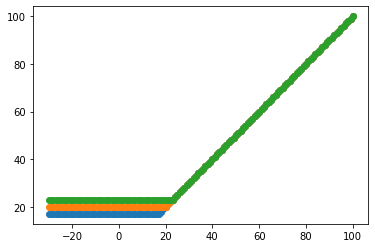

In [16]:
for model in models:
    model.value_iteration()
plt.scatter([i for i in range(-30,101)],models[0].best_delta)
plt.scatter([i for i in range(-30,101)],models[1].best_delta)
plt.scatter([i for i in range(-30,101)],models[2].best_delta)

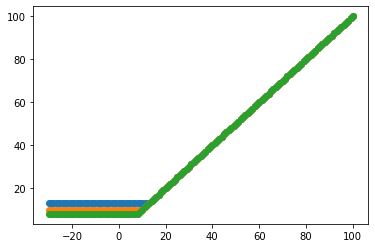

In [17]:
plt.scatter([i for i in range(-30,101)],models[3].best_delta)
plt.scatter([i for i in range(-30,101)],models[4].best_delta)
plt.scatter([i for i in range(-30,101)],models[5].best_delta)

<span style="font-family:Times New Roman; font-size:1.2em;">

From the simulation we know that the optimum strategy is: for inventories under a certain threshold, order up to that threshold and for inventories higher than that threshold, do nothing.
    

The two graphs has shown that if we fix h and increase b, the threshold will increase and vice versa. This makes sense beacuse we want to keep backlog small when it's relatively expensive.
    
    
</span>

# Part III

In [63]:
class Q_Learning():
    def __init__(self,gama,c,b,h,max_iter = 200000):
        self.Q = np.zeros((131,131))
        #since the reward is negative, we shall avoid using zero are initial values.
        self.Q -= 800
        self.gama = gama
        self.beta = 0.9
        self.c = c
        self.b = b
        self.h = h
        self.states = [i for i in range(-30,101)]
        self.max_iter = max_iter
        self.t = 1
        self.alpha = 0.9
        self.best_delta = []
        self.v = []
        self.test = []
        
    def update(self):
        r = lambda x, delta: -((delta-x)*self.c + self.h*int(x>=0)*x - x*self.b*int(x<0))     
        x_t = random.choice(self.states)
        epsilon = 0.2
        #explore and exploit
        for n in range(self.max_iter):
            if random.uniform(0, 1) < epsilon:
                #explore a random action
                delta_t = random.choice(self.possible_deltas(x_t))
                x_t_1 = max(delta_t - np.random.poisson(self.gama),-30)                
                self.Q[x_t+30,delta_t+30] = self.Q[x_t+30,delta_t+30]\
                + self.alpha*(r(x_t,delta_t)+self.beta*np.max(self.Q[x_t_1+30,x_t_1+30:])-self.Q[x_t+30,delta_t+30])
                self.t += 1
                x_t = x_t_1
            else:
                #exploit the current optimal feasible action (optimal actions in the set of actions
                #that are greater or equal to x_t)
                delta_t = np.argmax(self.Q[x_t+30,x_t+30:]) - 30
                x_t_1 = max(delta_t - np.random.poisson(self.gama),-30)                
                self.Q[x_t+30,delta_t+30] = self.Q[x_t+30,delta_t+30]\
                + self.alpha*(r(x_t,delta_t)+self.beta*np.max(self.Q[x_t_1+30,x_t_1+30:])-self.Q[x_t+30,delta_t+30])
                self.t += 1
                x_t = x_t_1
        
        for i in range(131):
            self.best_delta.append(np.argmax(self.Q[i])-30)
            self.v.append(max(self.Q[i]))
    
    #define possible actions given x:
    def possible_deltas(self, x):
        return self.states[x+30:]


In [64]:
states = [i for i in range(-30,101)]

In [65]:
test = DP(15,1,10,2)
test.value_iteration()

In [66]:
test_2 = Q_Learning(15,1,10,2)
test_2.update()

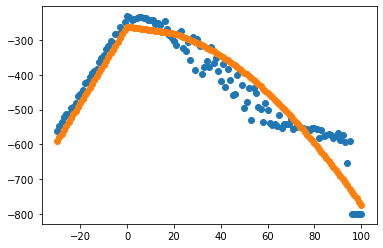

In [67]:
plt.scatter(states,test_2.v)
plt.scatter(states,test.v)

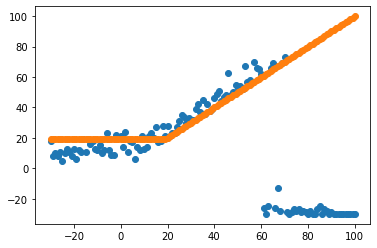

In [68]:
plt.scatter(states,test_2.best_delta)
plt.scatter(states,test.best_delta)

<span style="font-family:Times New Roman; font-size:1.2em;">

We can see that the Q-learning algorithm converges to the true values we have got from the dynamic programming.    
    
</span>